In [1]:
import sys
import os

# Completely suppress stderr output
sys.stderr = open(os.devnull, 'w')

# Now import everything
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../../') # Make sure this is the location for the ART library

import warning_utils
warning_utils.filter_end_user_warnings()

In [2]:
import pandas as pd
import numpy as np

from art.core import RecommendationEngine
import art.utility as utils
import pickle

In [3]:
print(np.__version__)

1.26.4


### Define directories

In [4]:
dataDir = '/code/DTRA_ART/DrugDesignData/'
modelBuildingDataDir = os.path.join(dataDir, 'modelBuildingData/')
resultsDir = os.path.join(dataDir, 'Results/')

In [12]:
artResultDir = resultsDir + 'ART_results/EbolaAllSpecies'
os.makedirs(artResultDir, exist_ok=True)

### Extract the data for `Ebola` into a data frame with `duplicate` SMILES

In [5]:
EbolaVirusAllSpeciesData_chEMBL_wMACAW = pd.read_csv(modelBuildingDataDir + "EbolavirusAllStrainData_chEMBL_wMACAW.csv")
EbolaVirusAllSpeciesData_chEMBL_wMACAW 

,ID,compound_id,Smiles,pPotency,StrainClassifier,pPotency_category,MACAW_1,MACAW_2,MACAW_3,MACAW_4,...,MACAW_6,MACAW_7,MACAW_8,MACAW_9,MACAW_10,MACAW_11,MACAW_12,MACAW_13,MACAW_14,MACAW_15
0,1,CHEMBL3596788,COc1nc(N)ncc1-c1cn(COCCO)cn1,4.000000,Ebola,3-10,-0.055210,-0.105419,0.140682,0.099235,...,-0.011542,0.008153,0.025994,0.079851,0.025986,0.002119,-0.020197,0.001032,-0.032108,-0.013864
1,2,CHEMBL3753489,Nc1nccc2c1ncn2C1=C[C@@H](CO)[C@H](O)[C@@H]1O,6.494850,Ebola,3-10,-0.049695,-0.209497,0.233947,0.179518,...,-0.085369,0.007020,0.047002,0.305714,-0.130110,-0.137501,0.114664,0.075753,-0.103020,0.085043
2,3,CHEMBL4751715,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.725842,Ebola,3-10,0.162986,-0.014673,-0.065779,0.016766,...,-0.014813,0.021646,0.055374,-0.057752,0.049748,-0.021710,-0.024241,-0.041792,-0.089228,0.077924
3,4,CHEMBL4792617,CCOP(=O)(Cc1cccc(COc2ccccc2OC2CCN(Cc3ccc4nc(-c...,5.603801,Ebola,3-10,0.185059,-0.017065,-0.053399,-0.003967,...,-0.039261,0.024677,0.051567,-0.064844,0.052826,-0.036045,-0.029885,-0.044119,-0.105069,0.080895
4,5,CHEMBL5085366,CCCCCCCCCCCCCCCC(=O)O[C@H]1[C@@H](O)[C@](C#N)(...,4.301030,Ebola,3-10,0.365461,-0.133926,-0.039091,-0.122343,...,-0.090686,-0.002894,0.004753,-0.122563,0.070689,-0.079462,-0.005863,-0.144990,-0.080888,0.227990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1108,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,-0.003205,0.092329,-0.033187,0.094475,...,0.099537,-0.009505,0.200324,-0.005978,0.002655,0.012498,0.210271,-0.111231,-0.028708,-0.075223
1108,1109,CHEMBL5398314,O=C(CCNCCC1CCN(Cc2ccccc2)CC1)Nn1c2ccccc2c2ccccc21,6.283997,ZaireEbola,3-10,-0.003205,0.092329,-0.033187,0.094475,...,0.099537,-0.009505,0.200324,-0.005978,0.002655,0.012498,0.210271,-0.111231,-0.028708,-0.075223
1109,1110,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.045988,0.082767,-0.034269,0.096566,...,0.108404,-0.072410,0.251483,-0.037040,-0.044583,0.075792,0.243158,-0.105551,-0.049675,-0.072812
1110,1111,CHEMBL5424177,O=C(CNCCC1CCN(Cc2ccccc2)CC1)NN(c1ccccc1)c1ccccc1,5.721246,ZaireEbola,3-10,-0.045988,0.082767,-0.034269,0.096566,...,0.108404,-0.072410,0.251483,-0.037040,-0.044583,0.075792,0.243158,-0.105551,-0.049675,-0.072812


### Prepare data to run `ART` on `Ebola` data with `duplicate` SMILES

Find Features and Response

In [6]:
input_var = [col for col in EbolaVirusAllSpeciesData_chEMBL_wMACAW.columns if col.startswith('MACAW_')]
print(f"MACAW Embeddings: {len(input_var)}")
print(input_var)

MACAW Embeddings: 15
['MACAW_1', 'MACAW_2', 'MACAW_3', 'MACAW_4', 'MACAW_5', 'MACAW_6', 'MACAW_7', 'MACAW_8', 'MACAW_9', 'MACAW_10', 'MACAW_11', 'MACAW_12', 'MACAW_13', 'MACAW_14', 'MACAW_15']


In [7]:
features = EbolaVirusAllSpeciesData_chEMBL_wMACAW[input_var].to_numpy()

In [8]:
response_var = ["pPotency"]
print(response_var)

['pPotency']


In [9]:
response = EbolaVirusAllSpeciesData_chEMBL_wMACAW[response_var].to_numpy()

And then save the data as a EDD style file (see "Importing a Study" here):

In [10]:
utils.save_edd_csv(features, response, input_var, modelBuildingDataDir + 'EbolaVirusAllSpeciesData_chEMBL_wMACAW_ARTready.csv', response_var)

### Predict response with ART

In [11]:
EbolaVirusAllSpeciesData_chEMBL_wMACAW_ARTready = pd.read_csv(modelBuildingDataDir + "EbolaVirusAllSpeciesData_chEMBL_wMACAW_ARTready.csv")
EbolaVirusAllSpeciesData_chEMBL_wMACAW_ARTready

,Line Name,Type,0.0
0,0,MACAW_1,-0.055210
1,1,MACAW_1,-0.049695
2,2,MACAW_1,0.162986
3,3,MACAW_1,0.185059
4,4,MACAW_1,0.365461
...,...,...,...
17787,1107,pPotency,6.283997
17788,1108,pPotency,6.283997
17789,1109,pPotency,5.721246
17790,1110,pPotency,5.721246


Let's now define the ART parameters needed for the prediction of production

In [13]:
user_params = {}
user_params['input_vars'] = input_var
user_params['response_vars'] = response_var
user_params['output_dir'] = artResultDir
user_params['alpha_exploration'] = 1
user_params['alpha_exploitation'] = 0
user_params['objective'] = 'maximize' # default is 'maximize'
user_params['num_exploration_recommendations'] = 5
user_params['num_exploitation_recommendations'] = 5
user_params['seed'] = 42
user_params['niter'] = 10000


#bounds = pd.DataFrame(columns=['Variable', 'Min','Max'])
#bounds['Variable'] = user_params['input_vars']
#bounds['Min'] = [0,0]
#bounds['Max'] = [10, 10]

In [15]:
art_params = {
   'input_vars': user_params['input_vars'], # list of input_variables. contains strings
   'response_vars': user_params['response_vars'], # list of response variables. contains string or strings. required when `initial_cycle = False`. Must not be present when `initial_cycle = True`
   #'bounds': bounds, # Dataframe with the upper and lower bounds for each variable. Required when `initial_cycle = True`. bounds.columns needs to return always ['Variable', 'Max', 'Min']. bounds['Variable'] needs to be the same as 'input_vars
   'objective': user_params['objective'], # default is 'maximize'. 'minimize' is also an option
   'num_recommendations': 0, # select this number based on plate format and replicates. For example for a 48-well plate in triplicates, then this should be set to 16
   'max_mcmc_cores': 4, # use 4 to be respectful of system resources 
   'seed': user_params['seed'], # seed for reproducibility
   'output_dir': user_params['output_dir'], # directory where the final model and the recommendations will be selected.
   'recommend': False,
   'cross_val': True,
   'result_suffix':'_C2',
   'num_tpot_models': 0,
   'niter': user_params['niter']
}


And then run ART without recommendations but with cross-validations to gauge how generalizable the results are:

ART identified 1,112 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See Data Preparation docs for a description of how ART infers design information. https://lbl-biosci.gitlab.io/ese/art/Data_Preparation/#labeling-lines-designs-replicates-oh-my


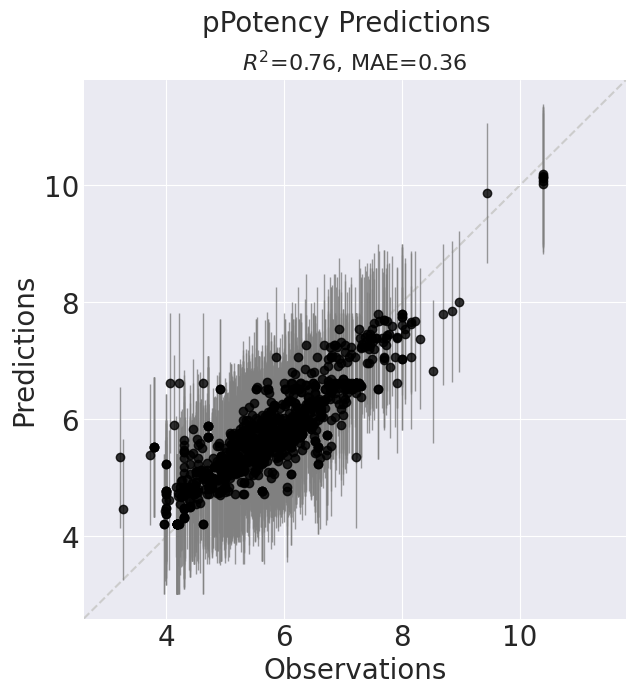

CPU times: user 1min 29s, sys: 7.73 s, total: 1min 37s
Wall time: 1min 54s


In [17]:
%%time
print('Training ART models ....')

art = RecommendationEngine(df=EbolaVirusAllSpeciesData_chEMBL_wMACAW_ARTready, **art_params)

print('ART training complete')

In [18]:
import shap
import matplotlib.pyplot as plt
import pickle 
import joblib
from joblib import load


import macaw
print(macaw.__version__)
from macaw import *

1.0.1


### Find SHAP values

We will now find which input features are more important by using SHAP analysis. First, lets initialize the library:

In [19]:
shap.initjs()

In [20]:
plt.style.use('default')

define a wrapper function that provides the ART prediction given and input X, for use by the SHAP library

In [21]:
def f(X):
    return art.predict(X)

convert the ART input data into the pandas dataframe that the SHAP library favors

In [22]:
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])

create and execute the explainer for the features values

In [ ]:
%%time
def f(X):
    return art.predict(X)
X_df = pd.DataFrame(data=art.X, columns=art_params['input_vars'])
explainer_e   = shap.Explainer(f, X_df)
shap_values_e = explainer_e(X_df)
shap.summary_plot(shap_values_e)
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


In [ ]:
shap.summary_plot(shap_values_e)

In [ ]:
shap.plots.heatmap(shap_values_e, instance_order=shap_values_e.sum(1), max_display=15)


## 2.1 Discovery of new hits specific to all viruses (data source Enamine_antiviralsData.csv)

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` above, which use 15-D MACAW embeddings as their input. The custom library ("Enamine_antiviralsData.csv") compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted pPotency.

In [26]:
EnamineAntiviralsData = pd.read_csv(dataDir + "Enamine/Enamine_Antiviral_Library_plated_3200cmpds_20251019.csv",
                                    sep=",", comment=None, skipinitialspace=True, engine="python", encoding="utf-8",          
                                    skiprows=1, skip_blank_lines=True)
print(f"Original Enamine data shape: {EnamineAntiviralsData.shape}")

smiles_train = EbolaVirusAllSpeciesData_chEMBL_wMACAW.Smiles

# Function to canonicalize SMILES using RDKit
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
        else:
            return None
    except:
        return None

# Canonicalize training SMILES and create a set for fast lookup
canonical_train = set()
for smi in smiles_train:
    canonical_smi = canonicalize_smiles(smi)
    if canonical_smi is not None:
        canonical_train.add(canonical_smi)

print(f"Number of unique SMILES in training set: {len(canonical_train)}")

# Add canonical SMILES column to Enamine data
EnamineAntiviralsData['Canonical_SMILES'] = EnamineAntiviralsData['SMILES'].apply(canonicalize_smiles)

# Filter out duplicates - keep only those NOT in training set
mask = ~EnamineAntiviralsData['Canonical_SMILES'].isin(canonical_train)
EnamineAntiviralsData_filtered = EnamineAntiviralsData[mask].copy()

# Remove the helper column if you don't need it
EnamineAntiviralsData = EnamineAntiviralsData_filtered.drop('Canonical_SMILES', axis=1)

print(f"Filtered Enamine data shape for validation: {EnamineAntiviralsData.shape}")
print(f"Removed {EnamineAntiviralsData.shape[0] - EnamineAntiviralsData_filtered.shape[0]} duplicate compounds from Enamine data set")

# Now use the filtered data
smi_lib = EnamineAntiviralsData.SMILES
print(f"Total compounds to screen: {len(smi_lib)}")
EnamineAntiviralsData.head()

Original Enamine data shape: (3200, 11)
Number of unique SMILES in training set: 540
Filtered Enamine data shape for validation: (3200, 11)
Removed 0 duplicate compounds from Enamine data set
Total compounds to screen: 3200


,SMILES,Catalog ID,MW,MW (desalted),ClogP,logS,HBD,HBA,TPSA,RotBonds,AnalogsFromREAL
0,COCC(C)NC(=O)NC1=NN=C(S1)C2CC2,Z410227912,256.326,256.326,1.231,-2.190,2,4,76.14,5,https://real.enamine.net/public-enum-files/Z41...
1,CN1C(=O)C=CN(CC(=O)NCC2CC2)C1=O,Z383167688,237.256,237.256,-0.042,-0.692,1,3,69.72,5,https://real.enamine.net/public-enum-files/Z38...
2,CCN(CC)CCNC(=O)C1=CC=CN=C1N2CCOCC2,Z235579208,306.404,306.404,1.583,-2.082,1,5,57.70,7,NaN
3,CCC(CNC(=O)CC=1C(C)=NOC1C)N2CCCC2,Z403694008,279.379,279.379,1.156,-0.660,1,3,58.37,7,https://real.enamine.net/public-enum-files/Z40...
4,CCC(C)(CNC(=O)CN1C=CC=CC1=O)N2CCOCC2,Z384461492,307.389,307.389,1.084,-1.180,1,4,61.88,7,https://real.enamine.net/public-enum-files/Z38...


Load MACAW transformer

In [ ]:
from joblib import load

macaw_file_path = os.path.join(modelBuildingDataDir, "EbolavirusAllStrainData_chEMBL_uM_MACAW_transformer.joblib")
mcw = load(macaw_file_path)
print(f" MACAW transformer loaded from: {macaw_file_path}")

Load pre-trained ART model

In [ ]:
ARTtrainedModelFile = os.path.join(artResultDir, 'art.cpkl')
with open(ARTtrainedModelFile, 'rb') as f:
    regr_pred = pickle.load(f)
print(f" ART model loaded from: {ARTtrainedModelFile}")

In [ ]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr_pred.predict(X1_lib)

Get predictions with uncertainty using ART's post_pred_stats

In [ ]:
# Pass X1_lib (features)
mean, std = regr_pred.post_pred_stats(X1_lib)

# Now use these for your results
EnamineAntiviralsData_predicted = EnamineAntiviralsData.copy()
EnamineAntiviralsData_predicted['pPotency_prediction'] = mean
EnamineAntiviralsData_predicted['pPotency_std'] = std

# Calculate 95% Confidence Intervals
EnamineAntiviralsData_predicted['pPotency_lower_95CI'] = mean - 1.96 * std
EnamineAntiviralsData_predicted['pPotency_upper_95CI'] = mean + 1.96 * std

# Convert to IC50
EnamineAntiviralsData_predicted['IC50(M)_prediction'] = 10 ** (-mean)
EnamineAntiviralsData_predicted['IC50(M)_lower_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_upper_95CI'])
EnamineAntiviralsData_predicted['IC50(M)_upper_95CI'] = 10 ** (-EnamineAntiviralsData_predicted['pPotency_lower_95CI'])

# Select and save results
EnamineAntiviralsData_predicted = EnamineAntiviralsData_predicted.filter(
    items=["SMILES", "pPotency_prediction", "pPotency_std", 
           "pPotency_lower_95CI", "pPotency_upper_95CI",
           "IC50(M)_prediction", "IC50(M)_lower_95CI", "IC50(M)_upper_95CI"]
)

EnamineAntiviralsData_predicted.to_csv(os.path.join(resultsDir + "EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_EnamineDatasets_predicted_all.csv"), index=False)
EnamineAntiviralsData_predicted[['SMILES']].to_csv(os.path.join(resultsDir + "EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_EnamineDatasets_predicted_all_SMILES.csv"), index=False)
print(f"Predictions saved with uncertainty estimates")
EnamineAntiviralsData_predicted

Let us represent the predictions of both models

In [ ]:
plt.figure(figsize=(4.7, 4.0), dpi=300)
plt.hist(Y1_lib_pred, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted potency")
plt.ylabel("Number of compounds")
#plt.axvline(x=5, color='r', linestyle='--', linewidth=2) # label='pPotency = 5.0 (minimum)'
#plt.axvline(x=6, color='g', linestyle='--', linewidth=2) # label='pPotency = 6.0 (good)'
#plt.axvline(x=7, color='b', linestyle='--', linewidth=2) # label='pPotency = 7.0 (excellent)'

# Legend on top, outside plot area
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon=False)

plt.grid(True, alpha=0.3)
plt.savefig(resultsDir + 'EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_validation.svg', bbox_inches='tight', dpi=300)
plt.savefig(resultsDir + 'EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_validation.png', bbox_inches='tight', dpi=300)
plt.show()

Let us have a look at the compounds:

In [ ]:
# Define multiple priority levels
high_priority_idx = np.where(Y1_lib_pred >= 7.0)[0]
medium_priority_idx = np.where((Y1_lib_pred >= 6.0) & (Y1_lib_pred < 7.0))[0]
low_priority_idx = np.where((Y1_lib_pred >= 5.0) & (Y1_lib_pred < 6))[0]

print(f"High priority (pPotency ≥ 7.0): {len(high_priority_idx)} compounds")
print(f"Medium priority (6 ≤ pPotency < 7.0): {len(medium_priority_idx)} compounds")
print(f"Low priority (5 ≤ pPotency < 6): {len(low_priority_idx)} compounds")

# Use the one you need
idx = high_priority_idx  # or combine them

### Top 20 compounds with higher pPotency

In [ ]:
# Get indices of top 20 compounds sorted by predicted pPotency (highest to lowest)
Y1_lib_pred = Y1_lib_pred.flatten() 
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Get the cutoff pPotency (minimum value in top 20)
cutoff_pPotency = Y1_lib_pred[top_20_idx[-1]]  # Last (20th) value

print(f"Top 20 compounds cutoff pPotency: {cutoff_pPotency:.2f}")
print(f"Highest predicted pPotency: {Y1_lib_pred[top_20_idx[0]]:.2f}")
print(f"Range of top 20: {cutoff_pPotency:.2f} - {Y1_lib_pred[top_20_idx[0]]:.2f}")

In [ ]:
# Get top 20 indices by highest predicted pPotency
top_20_idx = np.argsort(Y1_lib_pred)[::-1][:20]

# Create dataframe with top 20
EnamineAntiviralsData_top20 = EnamineAntiviralsData.iloc[top_20_idx].copy()

# Add pPotency_prediction rounded to 3 decimal places
EnamineAntiviralsData_top20['pPotency_prediction'] = Y1_lib_pred[top_20_idx].round(3)

# Add IC50 column (convert pPotency to Molar units)
# IC50 (M) = 10^(-pPotency)
EnamineAntiviralsData_top20['IC50 (M)'] = 10**(-Y1_lib_pred[top_20_idx])

# Add rank column at the beginning
EnamineAntiviralsData_top20.insert(0, 'Rank', range(1, 21))

# Calculate ranges
pPotency_max = Y1_lib_pred[top_20_idx[0]]   # Highest (best)
pPotency_min = Y1_lib_pred[top_20_idx[-1]]  # Lowest (cutoff)
IC50_min = 10**(-pPotency_max)              # Lowest IC50 (most potent)
IC50_max = 10**(-pPotency_min)              # Highest IC50 (least potent in top 20)
IC50_min_nM = IC50_min * 1e9
IC50_max_nM = IC50_max * 1e9

# Display information
print("-"*70)
print("Top 20 Compounds with Highest Predicted pPotency")
print("-"*70)
print("\nCutoff Values (20th ranked compound):")
print(f"  pPotency:    {pPotency_min:.3f}")
print(f"  IC50:        {IC50_max:.3e} M  ({IC50_max_nM:.2f} nM)")

print("\nBest Values (1st ranked compound):")
print(f"  pPotency:    {pPotency_max:.3f}")
print(f"  IC50:        {IC50_min:.3e} M  ({IC50_min_nM:.2f} nM)")


print("Range for Top 20 Compounds:")
print(f"pPotency Range:  {pPotency_min:.3f} - {pPotency_max:.3f}")
print(f"\nIC50 Range (M):  {IC50_max:.3e} - {IC50_min:.3e}")
#print(f"IC50 Range (nM): {IC50_max_nM:.2f} - {IC50_min_nM:.2f} nM")
#print(f"                 (Δ = {pPotency_max - pPotency_min:.3f})")
#print(f"                 (Fold change = {IC50_max/IC50_min:.1f}x)")


# Set pandas display options for scientific notation
pd.options.display.float_format = lambda x: f'{x:.3e}' if abs(x) < 0.01 or abs(x) > 1000 else f'{x:.3f}'

# Display the dataframe
EnamineAntiviralsData_top20 = EnamineAntiviralsData_top20.filter(
    items=["Rank", "SMILES", "pPotency_prediction", "IC50 (M)"]
)
EnamineAntiviralsData_top20

In [ ]:
EnamineAntiviralsData_top20.to_csv(os.path.join(resultsDir + "EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_EnamineAntiviralsData_top20.csv"), index=False)
EnamineAntiviralsData_top20[['SMILES']].to_csv(os.path.join(resultsDir + "EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_EnamineAntiviralsData_top20_SMILES.csv"), index=False)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import os
from PIL import Image


# Get molecules
molecules = [Chem.MolFromSmiles(smi) for smi in EnamineAntiviralsData_top20.SMILES[:50]]

# Create legends
legends = []
for idx, row in EnamineAntiviralsData_top20[:50].iterrows():
    legend = f"pIC50: {row['pPotency_prediction']:.3f}\nIC50: {row['IC50 (M)']:.2e} M"
    legends.append(legend)

# Generate PNG image
img = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=False, 
    legends=legends,
    returnPNG=False  # Returns PIL Image object
)

# Save PNG
output_png = resultsDir + 'EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_enamine_predictedCompounds.png'
img.save(output_png, dpi=(600, 600))
print(f" Saved PNG: {output_png}")

# Generate and save SVG
svg = Draw.MolsToGridImage(
    molecules, 
    subImgSize=(200, 200), 
    molsPerRow=5, 
    useSVG=True,
    legends=legends
)

output_svg = resultsDir + 'EbolaVirusAllSpecies/EbolaVirusAllSpecies_wART_enamine_predictedCompounds.svg'
with open(output_svg, 'w') as f:
    f.write(svg.data)
print(f" Saved SVG: {output_svg}")


display(img)  

### Extract the data for `Ebola` into a data frame without `duplicate` SMILES

In [ ]:
EbolaVirusData_chEMBL_noDuplicates = pd.read_csv(modelBuildingDataDir + "EbolaVirusData_chEMBL_wMACAW_noDuplicates_MLready.csv")
EbolaVirusData_chEMBL_noDuplicates

### Prepare to run `ART` on `Ebola` data without `duplicate` SMILES